# Variational AutoEncoder

(https://twitter.com/fchollet)<br>
Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Строим слой семплирования sampling layer


In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Строим энкодер encoder


In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Строим свой decoder


In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



## Учим VAE


In [14]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)


4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/10
547/547 [==============================] - 12s 18ms/step - loss: 326.3306 - reconstruction_loss: 324.1519 - kl_loss: 2.1787
Epoch 2/10
547/547 [==============================] - 10s 18ms/step - loss: 281.4977 - reconstruction_loss: 277.7753 - kl_loss: 3.7224
Epoch 3/10
547/547 [==============================] - 10s 18ms/step - loss: 272.2687 - reconstruction_loss: 268.4002 - kl_loss: 3.8684
Epoch 4/10
547/547 [==============================] - 10s 18ms/step - loss: 268.1687 - reconstruction_loss: 264.2902 - kl_loss: 3.8786
Epoch 5/10
547/547 [==============================] - 10s 18ms/step - loss: 266.1556 - reconstruction_loss: 262.2843 - kl_loss: 3.8713
Epoch 6/10
547/547 [==============================] - 10s 18ms/step - loss: 264.8840 - reconstruction_loss: 261.0162 - kl_loss: 3.8678
Epoch 7/10
547/547 [==============================] - 10s 18ms/step - loss: 263.8815 - reconstruction_loss: 260.0187 - kl_loss:

In [15]:
vae.fit(mnist_digits, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 10s 18ms/step - loss: 261.2595 - reconstruction_loss: 257.4427 - kl_loss: 3.8168
Epoch 2/50
547/547 [==============================] - 10s 18ms/step - loss: 260.9493 - reconstruction_loss: 257.1562 - kl_loss: 3.7931
Epoch 3/50
547/547 [==============================] - 10s 18ms/step - loss: 260.5515 - reconstruction_loss: 256.7706 - kl_loss: 3.7808
Epoch 4/50
547/547 [==============================] - 10s 18ms/step - loss: 260.1679 - reconstruction_loss: 256.3900 - kl_loss: 3.7779
Epoch 5/50
547/547 [==============================] - 10s 18ms/step - loss: 259.8158 - reconstruction_loss: 256.0544 - kl_loss: 3.7614
Epoch 6/50
547/547 [==============================] - 10s 18ms/step - loss: 259.6338 - reconstruction_loss: 255.8835 - kl_loss: 3.7503
Epoch 7/50
547/547 [==============================] - 10s 18ms/step - loss: 259.3241 - reconstruction_loss: 255.5641 - kl_loss: 3.7600
Epoch 8/50
547/547 [==============================] - 1

## Результат предсказания для цифры


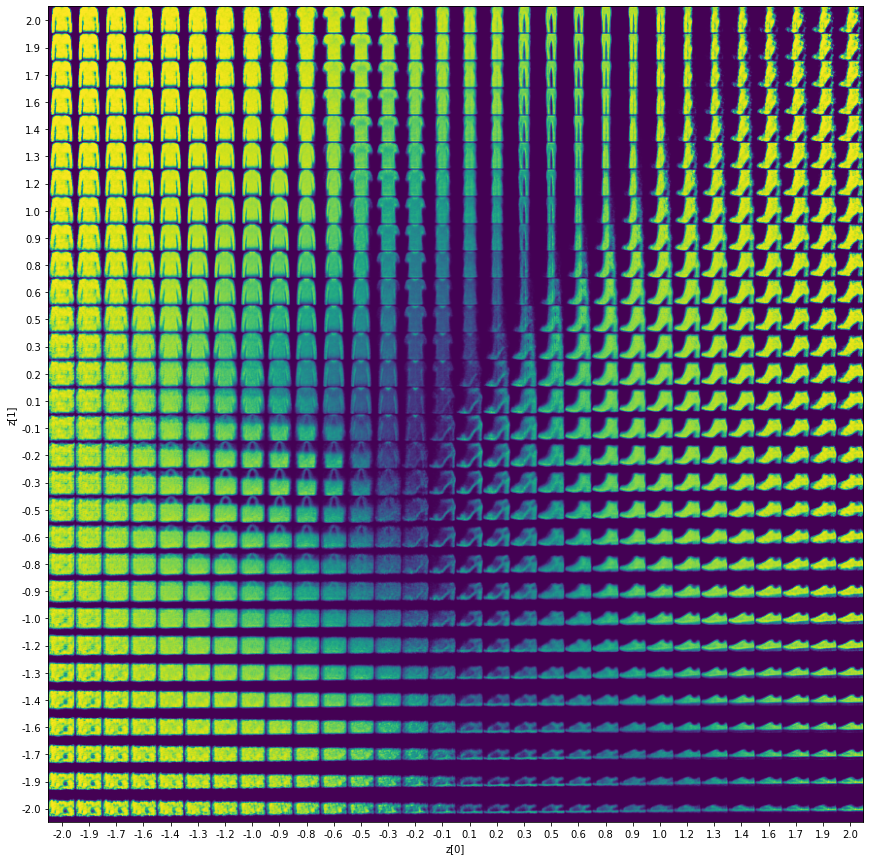

In [21]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent(encoder, decoder)


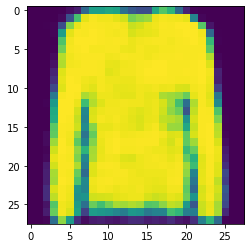

In [17]:
x_decoded = decoder.predict([[-1.990,1.5]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

## Посмотрим на кластеры в скрытом пространстве


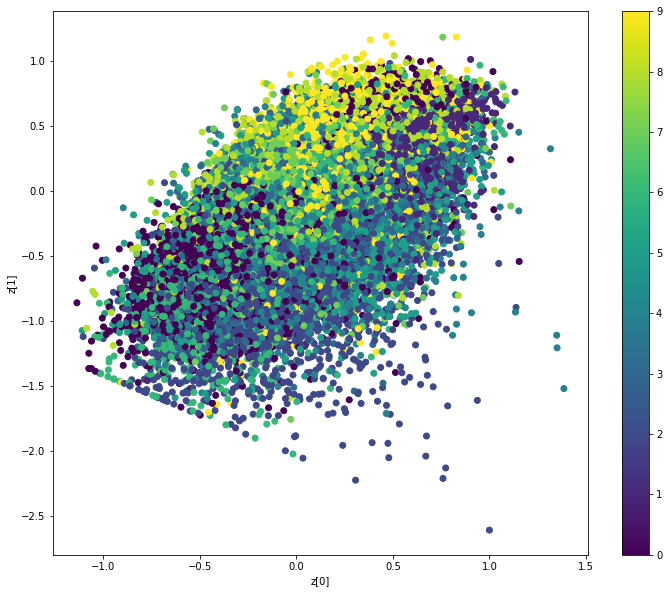

In [19]:

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)


Построим немного примеров генерации цифр:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

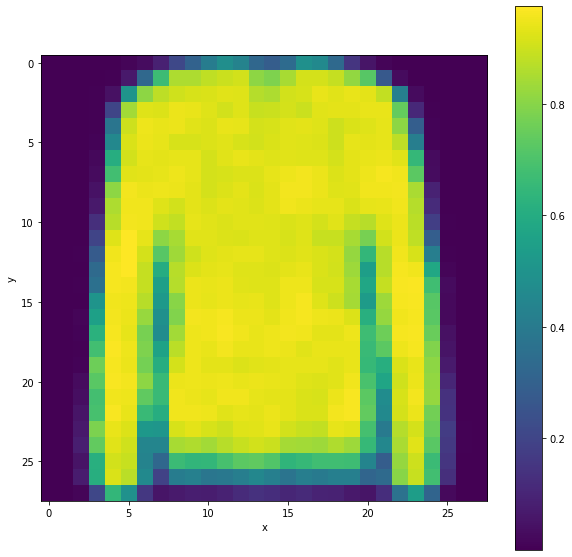

In [20]:

def plot_digit_from_decoder(decoder, z, digit_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    digit = decoder.predict(data)
    digit = digit.reshape(digit_size, digit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoder, [-1.5,1.], 28)